In [1]:
#Import the libraries that we are going to need
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
#Get de password
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [4]:
#Connecting with SQL
query = '''
WITH times_rented AS 
    (SELECT i.film_id, COUNT(*) AS times_rented
    FROM rental AS r
    JOIN inventory AS i USING (inventory_id)
    WHERE r.rental_date BETWEEN '2005-07-01' AND '2005-07-31'
    GROUP BY i.film_id)
SELECT f.film_id, f.length, f.rating, c.name as category, f.rental_rate, f.rental_duration, rc.times_rented,
    CASE 
        WHEN rc.times_rented > AVG(rc.times_rented) OVER () THEN 'high'
        WHEN rc.times_rented <= AVG(rc.times_rented) OVER () THEN 'low'
        ELSE 'unknow'
    END AS probability_of_rented
FROM film AS f
    JOIN film_category AS fc USING (film_id)
    JOIN category AS c USING (category_id)
    JOIN times_rented AS rc USING (film_id)
ORDER BY f.film_id ASC;
        '''

df = pd.read_sql_query(query, engine)
df

,film_id,length,rating,category,rental_rate,rental_duration,times_rented,probability_of_rented
0,1,86,PG,Documentary,0.99,6,7,high
1,2,48,G,Horror,4.99,3,2,low
2,3,50,NC-17,Documentary,2.99,7,4,low
3,4,117,G,Horror,2.99,5,11,high
4,5,130,G,Family,2.99,6,4,low
...,...,...,...,...,...,...,...,...
953,996,183,G,Documentary,0.99,6,2,low
954,997,179,NC-17,Music,0.99,4,2,low
955,998,105,NC-17,Horror,0.99,6,3,low
956,999,101,R,Children,2.99,5,6,low


In [5]:
df.shape

(958, 8)

In [6]:
#In this, we see the types of each column
df.dtypes

film_id                    int64
length                     int64
rating                    object
category                  object
rental_rate              float64
rental_duration            int64
times_rented               int64
probability_of_rented     object
dtype: object

In [7]:
df.describe()

,film_id,length,rental_rate,rental_duration,times_rented
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,115.490605,2.977474,4.969729,6.294363
std,287.541738,40.471844,1.643152,1.407593,2.786553
min,1.000000,46.000000,0.990000,3.000000,1.000000
25%,256.250000,80.250000,0.990000,4.000000,4.000000
50%,504.500000,114.000000,2.990000,5.000000,6.000000
75%,751.750000,150.000000,4.990000,6.000000,8.000000
max,1000.000000,185.000000,4.990000,7.000000,16.000000


In [8]:
df.head()

,film_id,length,rating,category,rental_rate,rental_duration,times_rented,probability_of_rented
0,1,86,PG,Documentary,0.99,6,7,high
1,2,48,G,Horror,4.99,3,2,low
2,3,50,NC-17,Documentary,2.99,7,4,low
3,4,117,G,Horror,2.99,5,11,high
4,5,130,G,Family,2.99,6,4,low


In [9]:
#We need to verificated if we have Nan values
df.isnull().sum()

film_id                  0
length                   0
rating                   0
category                 0
rental_rate              0
rental_duration          0
times_rented             0
probability_of_rented    0
dtype: int64

In [10]:
#Now is better if we do a copy of the data
df_copy=df.copy()

In [11]:
df_copy.set_index('film_id', inplace=True)
df_copy.head()

,length,rating,category,rental_rate,rental_duration,times_rented,probability_of_rented
film_id,,,,,,,
1,86,PG,Documentary,0.99,6,7,high
2,48,G,Horror,4.99,3,2,low
3,50,NC-17,Documentary,2.99,7,4,low
4,117,G,Horror,2.99,5,11,high
5,130,G,Family,2.99,6,4,low


In [12]:
#Checking the balance
df_copy['probability_of_rented'].value_counts()

probability_of_rented
low     539
high    419
Name: count, dtype: int64

In [13]:
#Categorical variables
categorical=df_copy[['rating','category']]
target= df_copy['probability_of_rented']

In [14]:
#Checking the unique values 
for col in categorical:
    print(f'{col}: {categorical[col].unique()}')

rating: ['PG' 'G' 'NC-17' 'PG-13' 'R']
category: ['Documentary' 'Horror' 'Family' 'Foreign' 'Comedy' 'Sports' 'Music'
 'Animation' 'Action' 'New' 'Sci-Fi' 'Classics' 'Games' 'Children'
 'Travel' 'Drama']


In [15]:
#Applying thee get dummies function
categorical= pd.get_dummies(categorical ,drop_first= True)
categorical.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
film_id,,,,,,,,,,,,,,,,,,,
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [16]:
#Now its time to do the same with the numerical values
numerical=df_copy.select_dtypes(include= ['int64','float64'])
numerical.head()

,length,rental_rate,rental_duration,times_rented
film_id,,,,
1,86,0.99,6,7
2,48,4.99,3,2
3,50,2.99,7,4
4,117,2.99,5,11
5,130,2.99,6,4


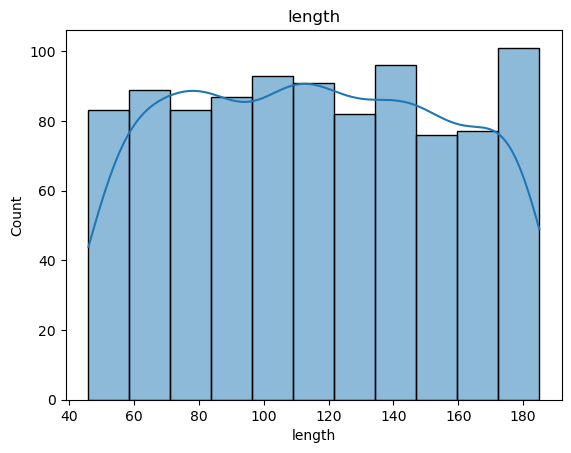

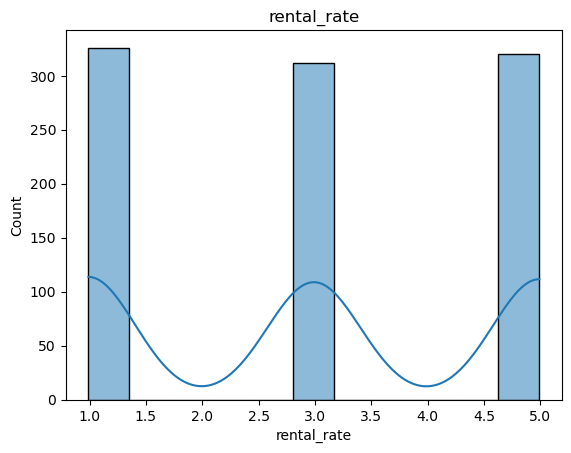

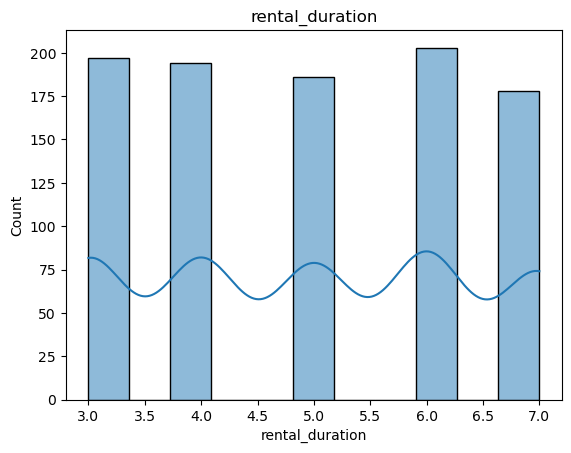

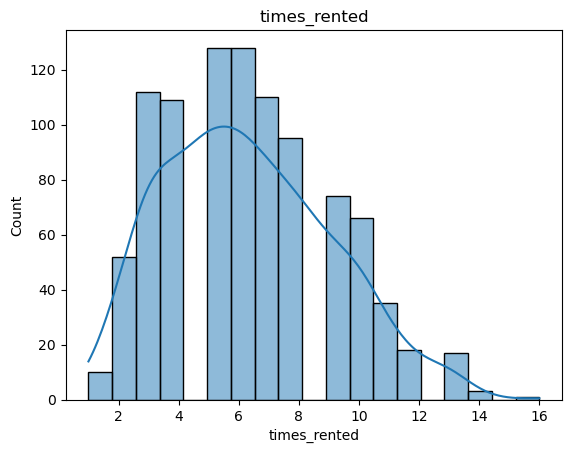

In [17]:
for i in numerical.columns:
    sns.histplot(numerical[i], kde= True)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title(i)
    plt.show()

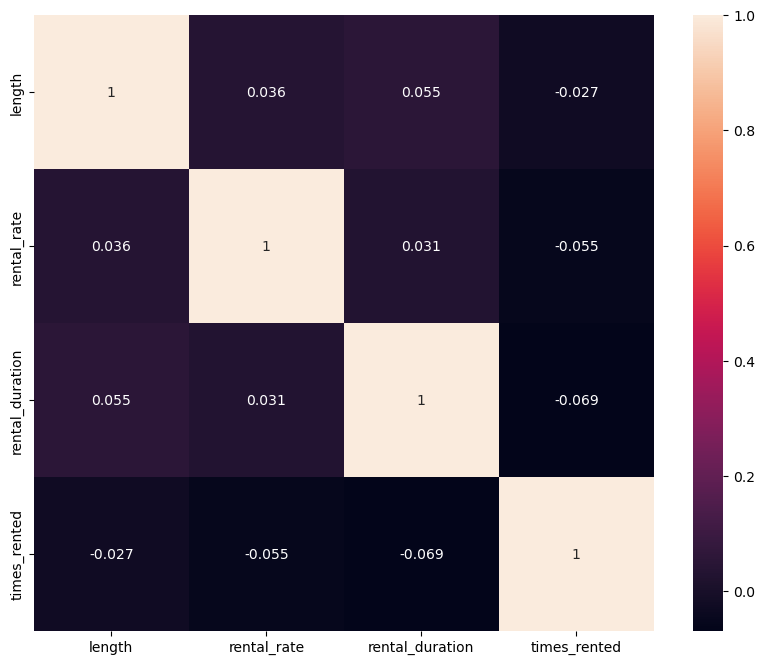

In [18]:
#Checking the multicollinearity
corr_matrix=numerical.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10,8))
ax= sns.heatmap(corr_matrix, annot=True)
plt.show()

In [19]:
#Preparing the data
X=pd.concat([numerical,categorical], axis=1)
y= target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=95, stratify=y)

In [20]:
#Training the model to after getting the results
classification= LogisticRegression(random_state=95,max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=95)

In [21]:
#Now the results

In [22]:
prediction= classification.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       126
         low       1.00      1.00      1.00       162

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

